# Using ITK in Python Pipelines

### Learning Objectives

* Learn how to write simple Python code with ITK
* Become familiar with the functional and object-oriented interfaces to ITK in Python
* Understand how to bridge ITK with machine learning libraries with [NumPy](https://numpy.org/)

# Working with NumPy and friends

* ITK is great at reading and processing images
* Some algorithms are not available in ITK
* NumPy is great at processing arrays in simple ways
* NumPy arrays can be read by many other Python packages
    * [matplotlib](https://matplotlib.org)
    * [scikit-learn](https://scikit-learn.org)
    * [PyTorch](https://pytorch.org)
    * [TensorFlow](https://www.tensorflow.org)
    * [scikit-image](https://scikit-image.org)
    * [OpenCV](https://opencv.org)

In [1]:
import itk
from itkwidgets import view

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image = itk.imread("data/KitwareITK.jpg")
view(image, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageRGBUC2; pro…

In [4]:
array = itk.array_from_image(image)
print(array[1,1])

[51 56 60]


Let go the other way around: NumPy array to an ITK image. First, we create an array with some values.

In [5]:
def make_gaussian(size, fwhm=3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be considered an effective radius.
    """

    x = np.arange(0, size, 1, np.float32)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


array = make_gaussian(11)

Let's look at the array. We use `matplotlib` or `itkwidgets.view` to do this.

(-0.5, 10.5, 10.5, -0.5)

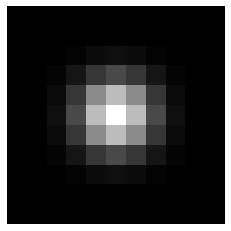

In [9]:
plt.gray()
plt.imshow(array)
plt.axis('off')

In [10]:
image = itk.image_view_from_array(array)
view(image, cmap='Grayscale', interpolation=False)

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_im…

## Exercises

### Exercise 1: Visualize an image
* Read an image with ITK
* Apply a filter
* Show both original image and filtered images with matplotlib

In [4]:
image = itk.imread('data/CBCT-TextureInput.png', itk.F)

In [ ]:
# %load solutions/2_ITK_in_Python_answers_Exercise1.py

# scikit-learn

* *scikit-learn* is a machine learning package in Python.
* scikit-learn is used to illustrate solving a problem using ITK and *NumPy* arrays.

In [15]:
import sklearn

First, we load 10 2D-images of circles with different radii and center position to which noise has been added and their corresponding ground truth segmentations.

itkSize2 ([50, 50])


Text(0.5, 1.0, 'Segmentation')

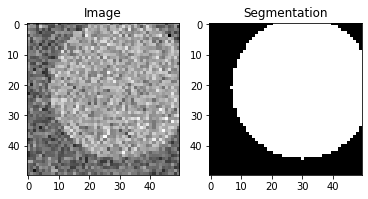

In [16]:
l_label = []
l_image = []

for i in range(0,10):
    image_name = 'data/sklearn/im%d.nrrd' % i
    image = itk.imread(image_name, itk.F)
    array = itk.array_from_image(image)
    l_image.append(array)
    
    label_name = 'data/sklearn/im%d_label.nrrd' % i
    image = itk.imread(label_name, itk.UC)
    array = itk.array_from_image(image)
    l_label.append(array)
    
size = itk.size(image)
print(size)

plt.subplot(1, 2, 1)
plt.imshow(l_image[0])
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(l_label[0])
plt.title("Segmentation")

The goal is to find the segmentation based on the input image.

We create arrays of data:
* X - the input samples
* Y - the target values

In [17]:
X0 = l_image[0].flatten()
X = X0

Y = l_label[0].flatten()

for i in range(1,10):
    X = np.concatenate((X, l_image[i].flatten()))
    Y = np.concatenate((Y, l_label[i].flatten()))

* We use a supervised learning methods based on Bayes’ theorem.
* The only information provided to the algorithm is the image intensity value.

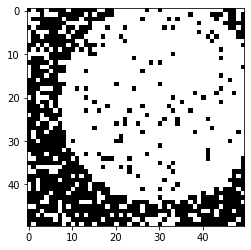

In [18]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X.reshape(-1,1), Y)

result = clf.predict(X0.reshape(-1,1)).reshape(size[0],size[1])
plt.imshow(result)

To improve our segmentation, we filter the input image with a median image filter and add this information as a second sample vector.

ITK is often used to read, reformat, denoise, and augment medical imaging data to improve the effectiveness of medical imaging models.

Text(0.5, 1.0, 'Median Filtered Image')

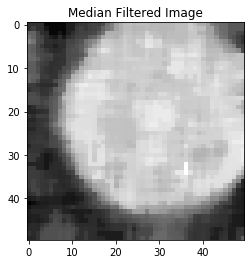

In [19]:
l_median = []
for i in range(0,10):
    image_name = 'data/sklearn/im%d.nrrd' % i
    image = itk.imread(image_name, itk.F)
    
    median=itk.median_image_filter(image, radius=3)
    
    array = itk.array_from_image(median)
    l_median.append(array)
    
plt.gray()
plt.imshow(l_median[0])
plt.title("Median Filtered Image")

In [20]:
M0 = l_median[0].flatten()
M = M0
X0 = np.concatenate((X0.reshape(-1,1),M0.reshape(-1,1)), axis=1)
for i in range(1,10):
    M = np.concatenate((M, l_median[i].flatten()))

X = np.concatenate((X.reshape(-1,1),M.reshape(-1,1)), axis=1)

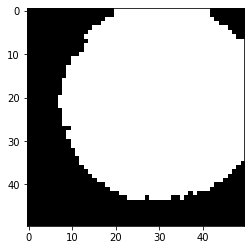

In [21]:
clf.fit(X, Y)
result = clf.predict(X0).reshape(50,50)
plt.imshow(result)

## Typical processing

* Resampling for consistent pixel grid size and spacing
* Image preprocessing
    * Bias field correction, e.g. `n4_bias_field_correction_image_filter`
    * Noise reduction, e.g. `smoothing_recursive_gaussian_image_filter`
    * Feature computation, e.g. texture, wavelet, or edge detector
* Converting ITK data to NumPy and organize the data as needed
* Train classifier
* Use classifier on new data
* Convert classifier result to ITK data
* Apply post processing filters
    * Fill holes, e.g. `binary_fillhole_image_filter`
    * Smoothing, e.g. `median_image_filter`

## Two ways of using ITK in Python

* Functional programming API
 * *Pythonic*
 * Eager execution
 * More concise
 * A few functions and filters are not available
* Object-oriented way
 * Set up processing pipelines
 * Delayed execution
 * Full access to ITK
 * Conserve memory
   * Optimally re-use and release pixel buffer memory
   * Stream process pipelines in chunks

## Let's start with the Pythonic way

In [22]:
image = itk.imread("data/CBCT-TextureInput.png", itk.ctype('float'))

In [23]:
filtered_image = itk.median_image_filter(image, radius = 3)

In [25]:
view(filtered_image, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF2; proxy o…

### Pythonic exercises

* In the example above, change the radius of the filter and observe the result.
* Replace filter with `mean_image_filter`
* Replace filter with `otsu_threshold_image_filter`
* Visualize results

Uncomment and change the radius of the filter and observe the result.

In [5]:
# median_filtered_image = itk.median_image_filter(image, radius = XX)
# view(median_filtered_image)

In [35]:
# %load solutions/2_Using_ITK_in_Python_real_world_filters_median.py

Uncomment and replace filter with `mean_image_filter`

In [36]:
# mean_filtered_image = itk.filter(image, radius = 5)
# view(mean_filtered_image)

In [39]:
# %load solutions/2_Using_ITK_in_Python_real_world_filters_mean.py

Uncomment and replace filter with `otsu_threshold_image_filter`

In [44]:
# otsu_filtered_image = itk.filter(image)
# view(otsu_filtered_image)

In [45]:
# %load solutions/2_Using_ITK_in_Python_real_world_filters_otsu.py

## Object-oriented

* Two types of C++ ITK objects
 * Smart pointers (hint: most ITK objects are smart pointers)
 * "Simple" objects
* Translates in two ways of creating objects in Python
 * `obj = itk.SmartPointerObjectType.New()` (use auto-completion to see if `New()` method exists)
 * `obj = itk.SimpleObjectType()`

## Examples of objects

* With `New()` method:
 * `itk.Image`
 * `itk.MedianImageFilter`
* Without `New()` method:
 * `itk.Index`
 * `itk.RGBPixel`


## Filters with object-oriented syntax

In [47]:
PixelType = itk.ctype('float')
image = itk.imread("data/CBCT-TextureInput.png", PixelType)

ImageType = itk.Image[PixelType, 2]
median_filter = itk.MedianImageFilter[ImageType, ImageType].New()
median_filter.SetInput(image)
median_filter.SetRadius(4)
median_filter.Update()
view(median_filter.GetOutput(), ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF2; proxy o…

### Object-oriented exercises

* In the example above, change the radius of the filter and observe the result.
* Replace filter with `MeanImageFilter`
* Replace filter with `OtsuThresholdImageFilter`
* Visualize results

Uncomment and change the radius of the filter and observe the result.

In [26]:
# median_filter = itk.MedianImageFilter[ImageType, ImageType].New()
# median_filter.SetInput(image)
# median_filter.SetRadius(XX)
# median_filter.Update()
# median_filtered_image = median_filter.GetOutput()
# view(median_filtered_image)

In [50]:
# %load solutions/2_Using_ITK_in_Python_real_world_filters_MedianFilter.py

Uncomment and edit to use `MeanImageFilter`

In [30]:
# mean_filter = itk.XX[ImageType, ImageType].New()
# mean_filter.SetInput(XX)
# mean_filter.SetRadius(XX)
# mean_filter.Update()
# mean_filtered_image = mean_filter.GetOutput()
# view(mean_filtered_image)

In [54]:
# %load solutions/2_Using_ITK_in_Python_real_world_filters_MeanFilter.py

Uncomment and replace filter with `OtsuThresholdImageFilter`

In [34]:
# InputImageType = itk.Image[itk.ctype('float'), 2]
# OutputImageType = itk.Image[itk.ctype('short'), 2]

# otsu_filter = itk.OtsuThresholdImageFilter[XX]
# XX

In [56]:
# %load solutions/2_Using_ITK_in_Python_real_world_filters_OtsuFilter.py

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageSS2; proxy …

## ITK Object-oriented Summary
* Has `New()` method?
  * Call `Update()` with filters!